In [167]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter, find_peaks_cwt

In [168]:
## Signal filtering methods.
def butter_bandpass(lowcut, highcut, signal_freq, order=5):
    nyquist_freq = 0.5 * signal_freq
    low = lowcut / nyquist_freq
    high = highcut / nyquist_freq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, signal_freq, order=5):
    b, a = butter_bandpass(lowcut, highcut, signal_freq, order=order)
    y = lfilter(b, a, data)
    return y

In [169]:
## Signal processing containers.
raw_signal = np.array([])
bandpass_signal = np.array([])
differentiated_signal = np.array([])
squared_signal = np.array([])
integrated_signal = np.array([])

## Signal filtering params.
signal_freq = 84.0
lowcut = 5.0
highcut = 15.0

## Detection.
fiducial_mark_idx = np.array([])
fiducial_mark_val = np.array([])
spki = 0.0 
npki = 0.0 
peaki = 0.0
threshold_1 = 0.0
threshold_2 = 0.0 
qrs_peak = np.array([])
noise_peak = np.array([])

peak_vals = np.array([])
spki_vals = np.array([])
npki_vals = np.array([])
threshold_1_vals = np.array([])
threshold_2_vals = np.array([])

## Realtime log detection.
logged_beats = np.array([])

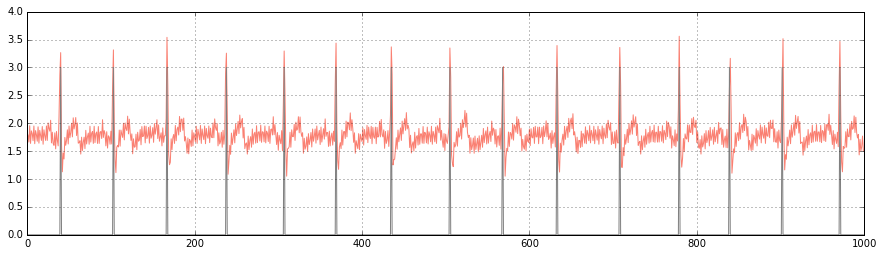

In [170]:
## Load and clean data.
with open("logs/s5/ecg/qrs_2016-01-29_14-09-03_333_datalog.txt") as f:
    content = f.readlines()
content = content[2000:3000]
raw_data = []
for line in content:
    log = line.rstrip().split(' ')
#     print log
    raw_signal = np.append(raw_signal, float(line.rstrip().split(' ')[2]))
    logged_beats = np.append(logged_beats, float(line.rstrip().split(' ')[3]))

plt.figure(figsize=(15,4))
plt.grid(True)
plt.plot(raw_signal, label="Original signal", color="salmon")
plt.plot(logged_beats * 3, label="Original signal", color="grey")

(0.0, 999.0, -0.86402875186605455, 1.0824399152404376)

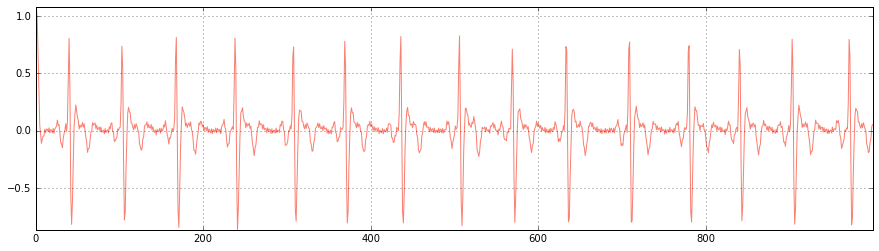

In [171]:
## Signal filtering - pass band 5-15 Hz.
bandpass_signal = butter_bandpass_filter(raw_signal, lowcut, highcut, signal_freq, order=1)
# bandpass_signal = bandpass_signal / max(bandpass_signal)

plt.figure(figsize=(15,4))
plt.plot(bandpass_signal, label="Bandpass signal", color="salmon")
plt.grid(True)
plt.axis("tight")

(0.0, 998.0, -0.94244918218401286, 0.56998126394630588)

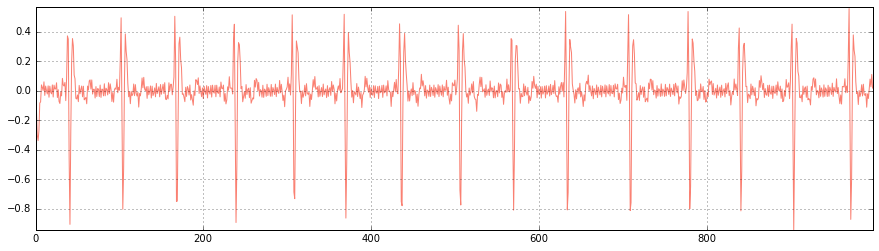

In [172]:
## Derivative - provide QRS slope info - five point derivative with 1 sample delay.
differentiated_signal = np.diff(bandpass_signal)
# differentiated_signal = differentiated_signal / max(differentiated_signal)

plt.figure(figsize=(15,4))
plt.plot(differentiated_signal, label="Differentiated signal", color="salmon")
plt.grid(True)
plt.axis("tight")

(0.0, 998.0, 8.9128924338091288e-09, 0.88821046099931467)

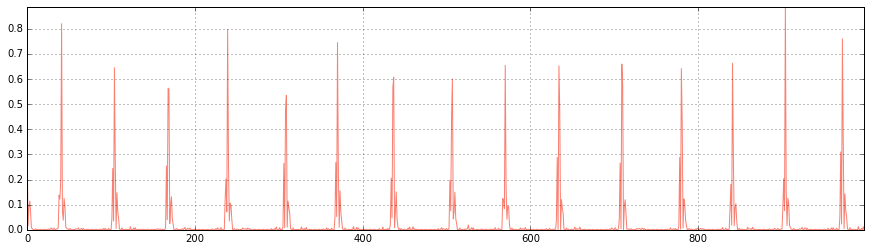

In [173]:
## Squaring - signal is squared point by point.
squared_signal = np.power(differentiated_signal, 2)
# squared_signal = squared_signal / max(squared_signal)

plt.figure(figsize=(15,4))
plt.plot(squared_signal, label="Squared signal", color="salmon")
plt.grid(True)
plt.axis("tight")

(0.0, 1009.0, 2.6772580262948362e-05, 0.15266108882762974)

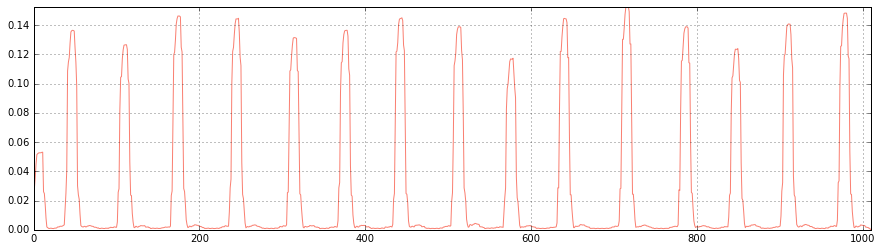

In [174]:
## Moving-window integration - to obtain waveform feature information in addition to the slope.
## Time window should be of the length of longest possible QRS complex - 30 samples (150 ms) for 200 samples/s.
N = 12
integrated_signal = np.convolve(squared_signal, np.ones((N,))/N)
# integrated_signal = integrated_signal / max(integrated_signal) 

plt.figure(figsize=(15,4))
plt.plot(integrated_signal, label="Integrated signal", color="salmon")
plt.grid(True)
plt.axis("tight")

(0.0, 1009.0, 0.0, 0.15266108882762974)

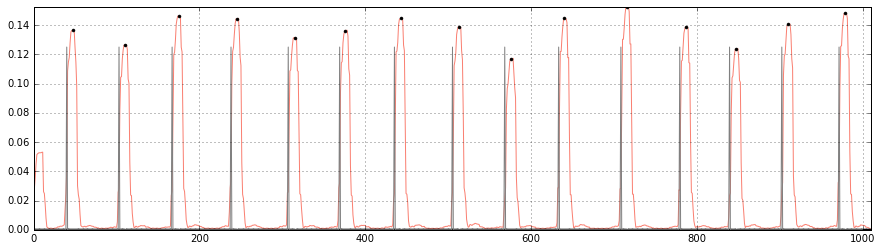

In [175]:
## Fiducial mark - peak detection.
peaks_indices = find_peaks_cwt(integrated_signal[:-1], np.arange(10, 15), noise_perc=0.1)

for peak_index in peaks_indices:
    fiducial_mark_idx = np.append(fiducial_mark_idx, peak_index)
    fiducial_mark_val = np.append(fiducial_mark_val, integrated_signal[peak_index])
    
fiducial_mark_indication = [0] * len(integrated_signal)
for peak_idx, peak_val in zip(fiducial_mark_idx, fiducial_mark_val):
    fiducial_mark_indication[int(peak_idx)] = peak_val

plt.figure(figsize=(15,4))
plt.plot(integrated_signal, label="Integrated signal", color="salmon")
plt.plot(fiducial_mark_indication, 'k.')
plt.plot(logged_beats / 8, label="Original signal", color="grey")
plt.grid(True)
plt.axis("tight")

In [176]:
## Thresholding detect peaks.
for peak_idx, peak_val in zip(fiducial_mark_idx, fiducial_mark_val):
    if peak_val > threshold_1:
        qrs_peak = np.append(qrs_peak, peak_idx)
        spki = 0.125 * peak_val + 0.875 * spki
        print "pulse - peak: %f, spki: %f, threshold1: %f" % (peak_val, spki, threshold_1)
        
        spki_vals = np.append(spki_vals, spki)
        npki_vals = np.append(npki_vals, npki)
        threshold_1_vals = np.append(threshold_1_vals, threshold_1)
        threshold_2_vals = np.append(threshold_2_vals, threshold_2)
    else:
        noise_peak = np.append(noise_peak, peak_idx)
        npki = 0.125 * peak_val + 0.875 * npki
        print "noise - peak: %f, npki: %f, threshold1: %f" % (peak_val, npki, threshold_1)
        
        spki_vals = np.append(spki_vals, spki)
        npki_vals = np.append(npki_vals, npki)
        threshold_1_vals = np.append(threshold_1_vals, threshold_1)
        threshold_2_vals = np.append(threshold_2_vals, threshold_2)
    
    peak_vals = np.append(peak_vals, peak_val)
    threshold_1 = npki + 0.25 * (spki - npki)
    threshold_2 = 0.5 * threshold_1

pulse - peak: 0.136464, spki: 0.017058, threshold1: 0.000000
pulse - peak: 0.126458, spki: 0.030733, threshold1: 0.004264
pulse - peak: 0.146199, spki: 0.045166, threshold1: 0.007683
pulse - peak: 0.144201, spki: 0.057546, threshold1: 0.011292
pulse - peak: 0.131347, spki: 0.066771, threshold1: 0.014386
pulse - peak: 0.136302, spki: 0.075462, threshold1: 0.016693
pulse - peak: 0.144618, spki: 0.084107, threshold1: 0.018866
pulse - peak: 0.138778, spki: 0.090941, threshold1: 0.021027
pulse - peak: 0.116723, spki: 0.094163, threshold1: 0.022735
pulse - peak: 0.144598, spki: 0.100468, threshold1: 0.023541
pulse - peak: 0.152581, spki: 0.106982, threshold1: 0.025117
pulse - peak: 0.138789, spki: 0.110958, threshold1: 0.026745
pulse - peak: 0.123421, spki: 0.112516, threshold1: 0.027739
pulse - peak: 0.140795, spki: 0.116050, threshold1: 0.028129
pulse - peak: 0.148221, spki: 0.120072, threshold1: 0.029013


(0.0, 14.0, 0.0, 0.12007172762308699)

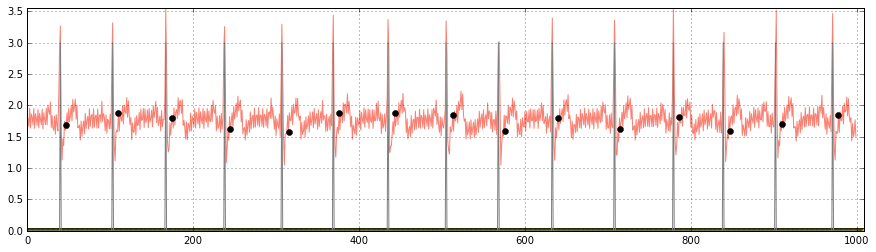

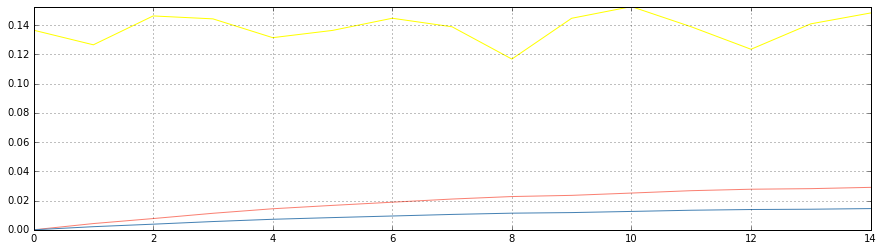

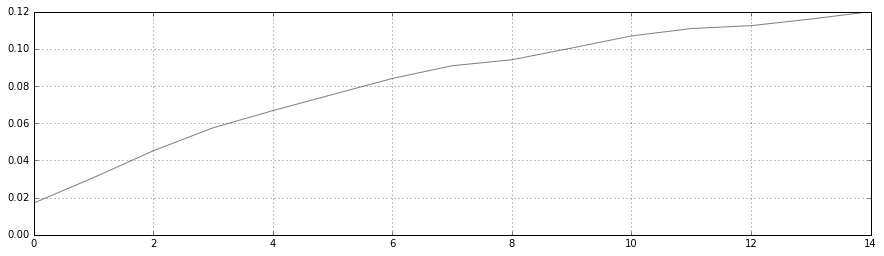

In [177]:
qrs_peak_indication = [0] * len(integrated_signal)
for peak in qrs_peak:
    qrs_peak_indication[int(peak)] = raw_signal[int(peak)]

noise_peak_indication = [0] * len(integrated_signal)
for peak in noise_peak:
    noise_peak_indication[peak] = raw_signal[peak]
    
plt.figure(figsize=(15,4))
plt.plot(raw_signal, label="Integrated signal", color="salmon")
plt.plot(qrs_peak_indication, 'ko')
plt.plot(noise_peak_indication, 'yo')
plt.plot(logged_beats * 3, label="Original signal", color="grey")
plt.grid(True)
plt.axis("tight")

plt.figure(figsize=(15,4))
plt.plot(threshold_1_vals, color="salmon", label='Threshold 1')
plt.plot(threshold_2_vals, color="steelblue", label='Threshold 2')
plt.plot(peak_vals, color="yellow", label='Peak')
plt.grid(True)
plt.axis('tight')

plt.figure(figsize=(15,4))
plt.plot(spki_vals, color="grey", label='Spki')
plt.plot(npki_vals, color="steelblue", label='Npki')
plt.grid(True)
plt.axis('tight')

(0.0, 1009.0, 0.0, 4.0)

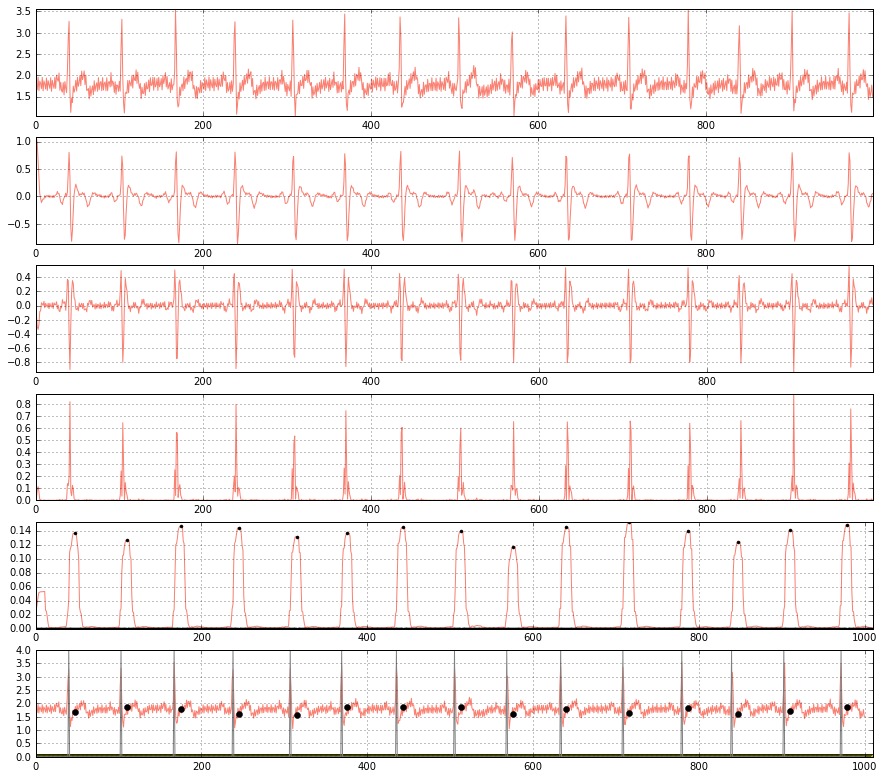

In [178]:
## Plot everything.
plt.figure(figsize=(15,18))
plt.subplot(811)
plt.plot(raw_signal, label="Original signal", color="salmon")
plt.grid(True)
plt.axis("tight")

plt.subplot(812)
plt.plot(bandpass_signal, label="Bandpass signal", color="salmon")
plt.grid(True)
plt.axis("tight")

plt.subplot(813)
plt.plot(differentiated_signal, label="Differentiated signal", color="salmon")
plt.grid(True)
plt.axis("tight")

plt.subplot(814)
plt.plot(squared_signal, label="Squared signal", color="salmon")
plt.grid(True)
plt.axis("tight")

fiducial_mark_indication = [0] * len(integrated_signal)
for peak_idx, peak_val in zip(fiducial_mark_idx, fiducial_mark_val):
    fiducial_mark_indication[int(peak_idx)] = peak_val
plt.subplot(815)
plt.plot(integrated_signal, label="Integrated signal", color="salmon")
plt.plot(fiducial_mark_indication, 'k.')
plt.grid(True)
plt.axis("tight")

qrs_peak_indication = [0] * len(integrated_signal)
for peak in qrs_peak:
    qrs_peak_indication[int(peak)] = raw_signal[int(peak)]
noise_peak_indication = [0] * len(integrated_signal)
for peak in noise_peak:
    noise_peak_indication[int(peak)] = raw_signal[int(peak)]
plt.subplot(816)
plt.plot(raw_signal, label="Integrated signal", color="salmon")
plt.plot(qrs_peak_indication, 'ko')
plt.plot(noise_peak_indication, 'yo')
plt.plot(logged_beats * 4, label="Original signal", color="grey")
plt.grid(True)
plt.axis("tight")
